1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)
d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_4']
Received: inputs=Tensor(shape=(32, 128, 128, 1))
  warnings.warn(msg)
d:\Venv\envs\TarRec\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_4']
Received: inputs=Tensor(shape=(None, 128, 128, 1))
  warnings.warn(msg)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.4499 - loss: 1.7652 - val_accuracy: 0.7917 - val_loss: 0.5566 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7968 - loss: 0.5671 - val_accuracy: 1.0000 - val_loss: 0.2141 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9116 - loss: 0.2760 - val_accuracy: 1.0000 - val_loss: 0.1140 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9565 - loss: 0.1843 - val_accuracy: 1.0000 - val_loss: 0.0774 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9551 - loss: 0.1318 - val_accuracy: 1.0000 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9746 - loss: 0.0855 - val_accuracy: 1.0000 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9590 

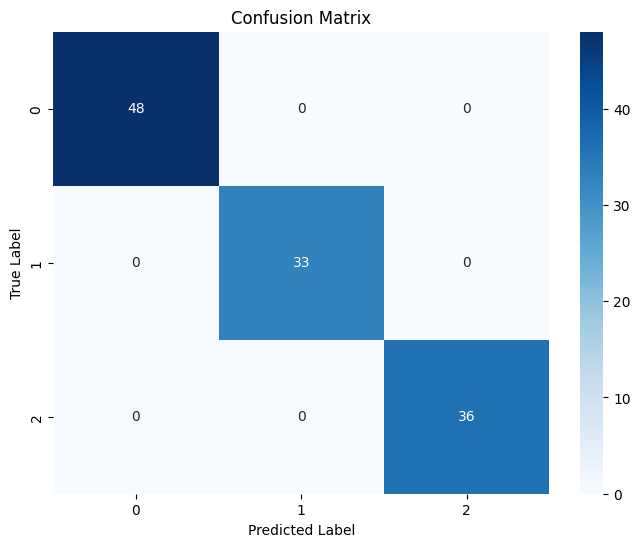

✅ 融合模型已保存为 cnn_fusion_model_wavelet_mfcc_dd.keras


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# **1️⃣ 加载训练好的 CNN 模型**
model_mfcc = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_MFCC_model.keras")
model_wavelet = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_wavelet_model_abs.keras")
model_dd = load_model(r"D:\Dataset\Marine-Mammal-Target-Classification\03_CNN\cnn_DelayDoppler_model.keras")

# **2️⃣ 创建一个虚拟输入，使 Sequential 模型能正常工作**
dummy_input_shape = (1, 128, 128, 1)  # (H, W, C)，根据你数据的实际形状调整
dummy_input = tf.random.normal(dummy_input_shape)
model_mfcc.predict(dummy_input)
model_wavelet.predict(dummy_input)
model_dd.predict(dummy_input)

# **3️⃣ 提取特征**
feature_extractor_mfcc = Model(inputs=model_mfcc.inputs, outputs=model_mfcc.get_layer("dense_2").output)
feature_extractor_wavelet = Model(inputs=model_wavelet.inputs, outputs=model_wavelet.get_layer("dense_2").output)
feature_extractor_dd = Model(inputs=model_dd.inputs, outputs=model_dd.get_layer("dense_8").output)

# **4️⃣ 加载测试数据**
X_test_mfcc = np.load(r"D:\Dataset\Temp_Results\MFCC\X_test_mfcc_cnn.npy")
X_test_wavelet = np.load(r"D:\Dataset\Temp_Results\Wavelet\X_test_cwt_abs.npy")
X_test_wavelet = np.expand_dims(X_test_wavelet, axis=-1)
X_test_dd = np.load(r"D:\Dataset\Temp_Results\DelayDoppler\X_test_dd_cnn.npy")
Y_test = np.load(r"D:\Dataset\Temp_Results\Train_Test\y_test.npy")


# 归一化数据
X_test_mfcc = X_test_mfcc.astype(np.float32) / 255.0
X_test_wavelet = X_test_wavelet.astype(np.float32) / 255.0
X_test_dd = X_test_dd.astype(np.float32) / 255.0


# **5️⃣ 提取三个模型的特征**
features_mfcc = feature_extractor_mfcc.predict(X_test_mfcc)
features_wavelet = feature_extractor_wavelet.predict(X_test_wavelet)
features_dd = feature_extractor_dd.predict(X_test_dd)

# **6️⃣ 拼接特征**
fused_features = np.concatenate([features_mfcc, features_wavelet, features_dd], axis=1)  # 按列拼接

# **7️⃣ 处理标签**
num_classes = len(np.unique(Y_test))
Y_test = to_categorical(Y_test, num_classes)

# **8️⃣ 构建融合模型**
input_dim = fused_features.shape[1]  # 拼接后的特征维度
input_layer = Input(shape=(input_dim,))

x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.4)(x)
x = Dense(num_classes, activation='softmax')(x)

fusion_model = Model(inputs=input_layer, outputs=x)

# **9️⃣ 编译模型**
fusion_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# **🔟 训练模型**
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = fusion_model.fit(fused_features, Y_test, epochs=30, batch_size=32,
                           validation_split=0.2, callbacks=[reduce_lr, early_stopping])

# **1️⃣1️⃣ 评估融合模型**
test_loss, test_acc = fusion_model.evaluate(fused_features, Y_test, verbose=2)
print(f"\n✅ 融合模型测试集准确率: {test_acc:.4f}")

# **1️⃣2️⃣ 计算分类报告和混淆矩阵**
Y_pred = fusion_model.predict(fused_features)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

print("\n📊 分类报告:")
print(classification_report(Y_true, Y_pred_classes))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y_true), yticklabels=np.unique(Y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **1️⃣3️⃣ 保存最终融合模型**
fusion_model.save("cnn_conncatenate_fusion_model_all_model.keras")
print("✅ 融合模型已保存为 cnn_conncatenate_fusion_model_all_model.keras")
